# Test: Correctness Evaluation of Annotat3d Image Processing Operations

This notebook implements bitwise comparisons between ANnotat3d custum operations and well stablished open frameworks for image processing. 

In [2]:
import os
notebook_name = "test_fill_holes"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

Plots will be saved to: test_fill_holes_plots


## Import libraries

Assures that the harpia module has already been compiled with cython, before (command: python3 setup.py)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, io
from skimage.color import rgb2gray

# workaround to allow importing harpia python module
import sys
sys.path.append("../../")

import harpia.morphology.operations_binary as harpia_binary
import harpia.morphology.operations_grayscale as harpia_grayscale


## Framework

In [4]:
def custum_line_kernel3D():
    kernel_2d = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]], dtype=np.int32)
    # Stack the 2D kernel to form a 3D kernel (3 layers)
    kernel_3d = np.stack([kernel_2d, kernel_2d, kernel_2d])
    return kernel_3d

In [5]:
def custum_kernel3D():
    kernel_2d = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.int32)
    # Stack the 2D kernel to form a 3D kernel (3 layers)
    kernel_3d = np.stack([kernel_2d, kernel_2d, kernel_2d])
    return kernel_3d

In [6]:
def custum_kernel2D():
    kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.int32)
    kernel = kernel.reshape(1, kernel.shape[0], kernel.shape[1])
    return kernel

In [7]:
def load_image(path, xsize, ysize, zsize, dtype, dtype_out):
    img = np.fromfile(path, dtype=dtype)
    img = img.reshape((zsize, ysize, xsize))
    img = img.astype(dtype = dtype_out)
    return img

In [8]:
# Function to compare the results
def show_results_diff(result_custum, original_image=None, plot=False, operation = "", framework = "", 
                 slice_num = 0, figsize=(18, 6), save_path=None):  
    fontsize = 18
    # Perform bitwise comparison
    bitwise_diff = np.abs(original_image.astype(np.int32) - result_custum.astype(np.int32))
    
    if(plot):
        if(len(original_image.shape)==3):
            original_slice = original_image[slice_num,:,:]
            slice_custum = result_custum[slice_num,:,:]
            slice_diff = bitwise_diff[slice_num,:,:]
        # Visual comparison
        plt.figure(figsize=figsize)

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title("Original Image", fontsize = fontsize)
        plt.axis('off')

        # Custum result
        plt.subplot(1, 3, 2)
        plt.imshow(slice_custum, cmap='gray')
        plt.title(f"Annotat3d {operation}", fontsize = fontsize)
        plt.axis('off')

        # Bitwise difference
        plt.subplot(1, 3, 3)
        plt.imshow(slice_diff, cmap='hot')
        plt.title("Bitwise Difference", fontsize = fontsize)
        plt.axis('off')

        plt.tight_layout()
        
        # Save the plot if a save path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        
        plt.show()
    
    return 

In [9]:
def show_results(result_custum, original_image=None, plot=False, operation = "", framework = "", 
                 slice_num = 0, figsize=(18, 6), save_path=None):  
    fontsize = 18
    # Perform bitwise comparison
    bitwise_diff = np.abs(original_image.astype(np.int32) - result_custum.astype(np.int32))
    
    if(plot):
        if(len(original_image.shape)==3):
            original_slice = original_image[slice_num,:,:]
            slice_custum = result_custum[slice_num,:,:]
            slice_diff = bitwise_diff[slice_num,:,:]
        # Visual comparison
        plt.figure(figsize=figsize)

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title("Original Image", fontsize = fontsize)
        plt.axis('off')
        
        # Custum result
        plt.subplot(1, 2, 2)
        plt.imshow(slice_custum, cmap='gray')
        plt.title(f"Annotat3d {operation}", fontsize = fontsize)
        plt.axis('off')

        plt.tight_layout()
        
        # Save the plot if a save path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        
        plt.show()
    
    return 

In [10]:
def process_image(data, plot=False, dtype='int32'):
    zsize, ysize, xsize = data.shape  # Get dimensions
    binarized_data = np.empty_like(data, dtype = dtype)  # Prepare output array of same shape

    for slice_idx in range(zsize):
        slice_data = data[slice_idx, :, :]

        # Find min and max for the current slice
        min_val = slice_data.min()
        max_val = slice_data.max()

        # Compute threshold
        threshold = (max_val + min_val) // 2

        # Apply threshold to the slice to create a binary image
        binarized_slice = np.where(slice_data >= threshold, 1, 0)

        # Store the binarized slice in the output array
        binarized_data[slice_idx, :, :] = binarized_slice

    # Plot the first slice if plot flag is True
    if plot:
        plt.figure(figsize=(10, 4))

        # Plot original first slice
        plt.subplot(1, 2, 1)
        plt.imshow(data[0, :, :], cmap='gray')
        plt.title('Original First Slice')
        plt.axis('off')

        # Plot binarized first slice
        plt.subplot(1, 2, 2)
        plt.imshow(binarized_data[0, :, :], cmap='gray')
        plt.title('Binarized First Slice')
        plt.axis('off')

        plt.show()

    return binarized_data

In [11]:
def compare_slices(array1, array2, axis=0):
    """
    Compare two 3D NumPy arrays slice by slice along a given axis and identify differing slices.

    Parameters:
        array1 (numpy.ndarray): The first 3D array.
        array2 (numpy.ndarray): The second 3D array.
        axis (int): The axis along which to compare slices (default is 0, i.e., along the z-axis).

    Returns:
        list: A list of indices where the slices are different.
    """
    # Ensure both arrays have the same shape
    if array1.shape != array2.shape:
        raise ValueError("Arrays must have the same shape for comparison.")

    # Initialize list to store indices of differing slices
    differing_slices = []

    # Iterate over slices along the specified axis
    for idx in range(array1.shape[axis]):
        # Extract the slices along the specified axis
        slice1 = np.take(array1, idx, axis=axis)
        slice2 = np.take(array2, idx, axis=axis)

        # Compare slices
        if not np.array_equal(slice1, slice2):
            differing_slices.append(idx)

    return differing_slices
 

## Read binary image

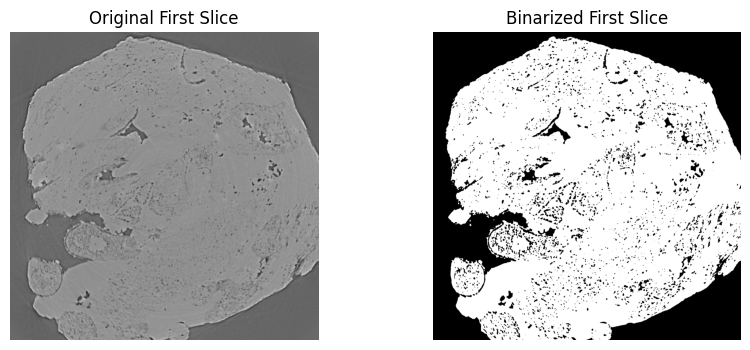

In [22]:
# original img
xsize = 1540
ysize = 1540
zsize_original = 1000
zsize = 1000
image3 = load_image("/ibira/lnls/labs/tepui/home/egon.borges/workshop/Recon_fdk__tomo_z1_930_z1z2_1000_esp_1264_expt_1s_000_1540x1540x1000_float32.raw", xsize, ysize, zsize_original,'float32', 'float32')
image3 = process_image(image3, True, 'int16')
image3 = image3[:zsize,:,:] #reduce size
image3_slice = image3[0,:,:]
image3_slice3D = np.expand_dims(image3_slice, axis=-1).reshape((1, ysize, xsize))

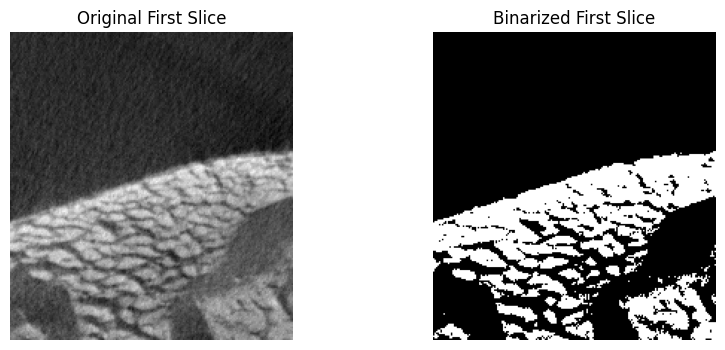

In [23]:
# original img
xsize = 190
ysize = 207
zsize_original = 100
zsize = 100
image1 = load_image("../../example_images/grayscale/crua_A_190x207x100_16b.raw", xsize, ysize, zsize_original,'uint16', 'int32')
image1 = image1[:zsize,:,:] #reduce size
image1 = process_image(image1, True, 'int16')
image1_slice = image1[0,:,:]
image1_slice3D = np.expand_dims(image1_slice, axis=-1).reshape((1, ysize, xsize))

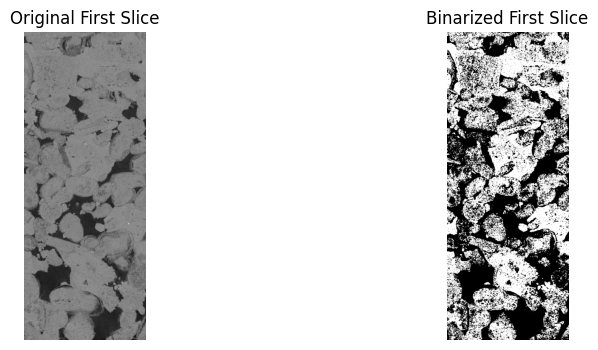

In [24]:
# original img
xsize = 600
ysize = 1520
zsize_original = 1520
zsize = 1520
image2 = load_image("/ibira/lnls/labs/tepui/home/camila.araujo/work/harpia/example_images/grayscale/ILSIMG_600x1520x1520_16bits.raw", xsize, ysize, zsize_original,'uint16', 'int32')
image2 = process_image(image2, True, 'int16')
image2 = image2[:zsize,:,:] #reduce size
image2_slice = image2[0,:,:]
image2_slice3D = np.expand_dims(image2_slice, axis=-1).reshape((1, ysize, xsize))

## Fill Holes 2D

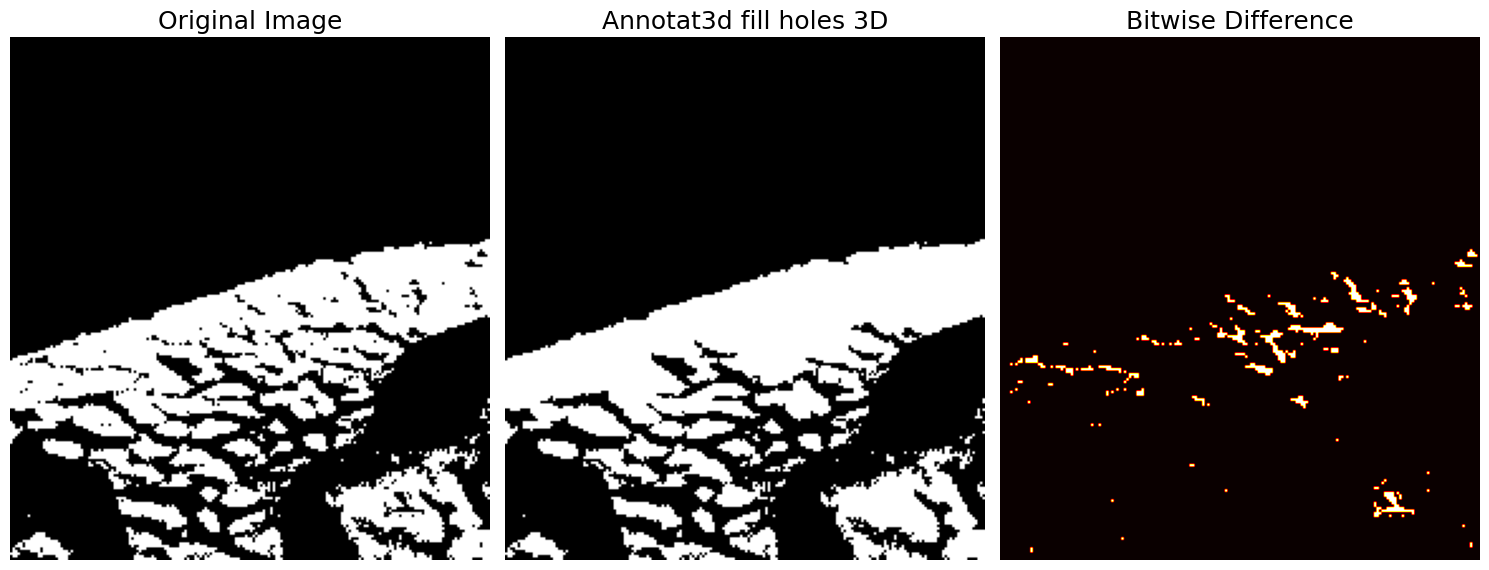

In [25]:
#Custum operation
result_custum = harpia_binary.fill_holes(image1_slice3D)

filename = f"{output_dir}/binary_fill_holes1_2D.png"
show_results_diff(result_custum, image1_slice3D, plot=True, operation = "fill holes 3D", slice_num=0, figsize = (15,30), save_path=filename)

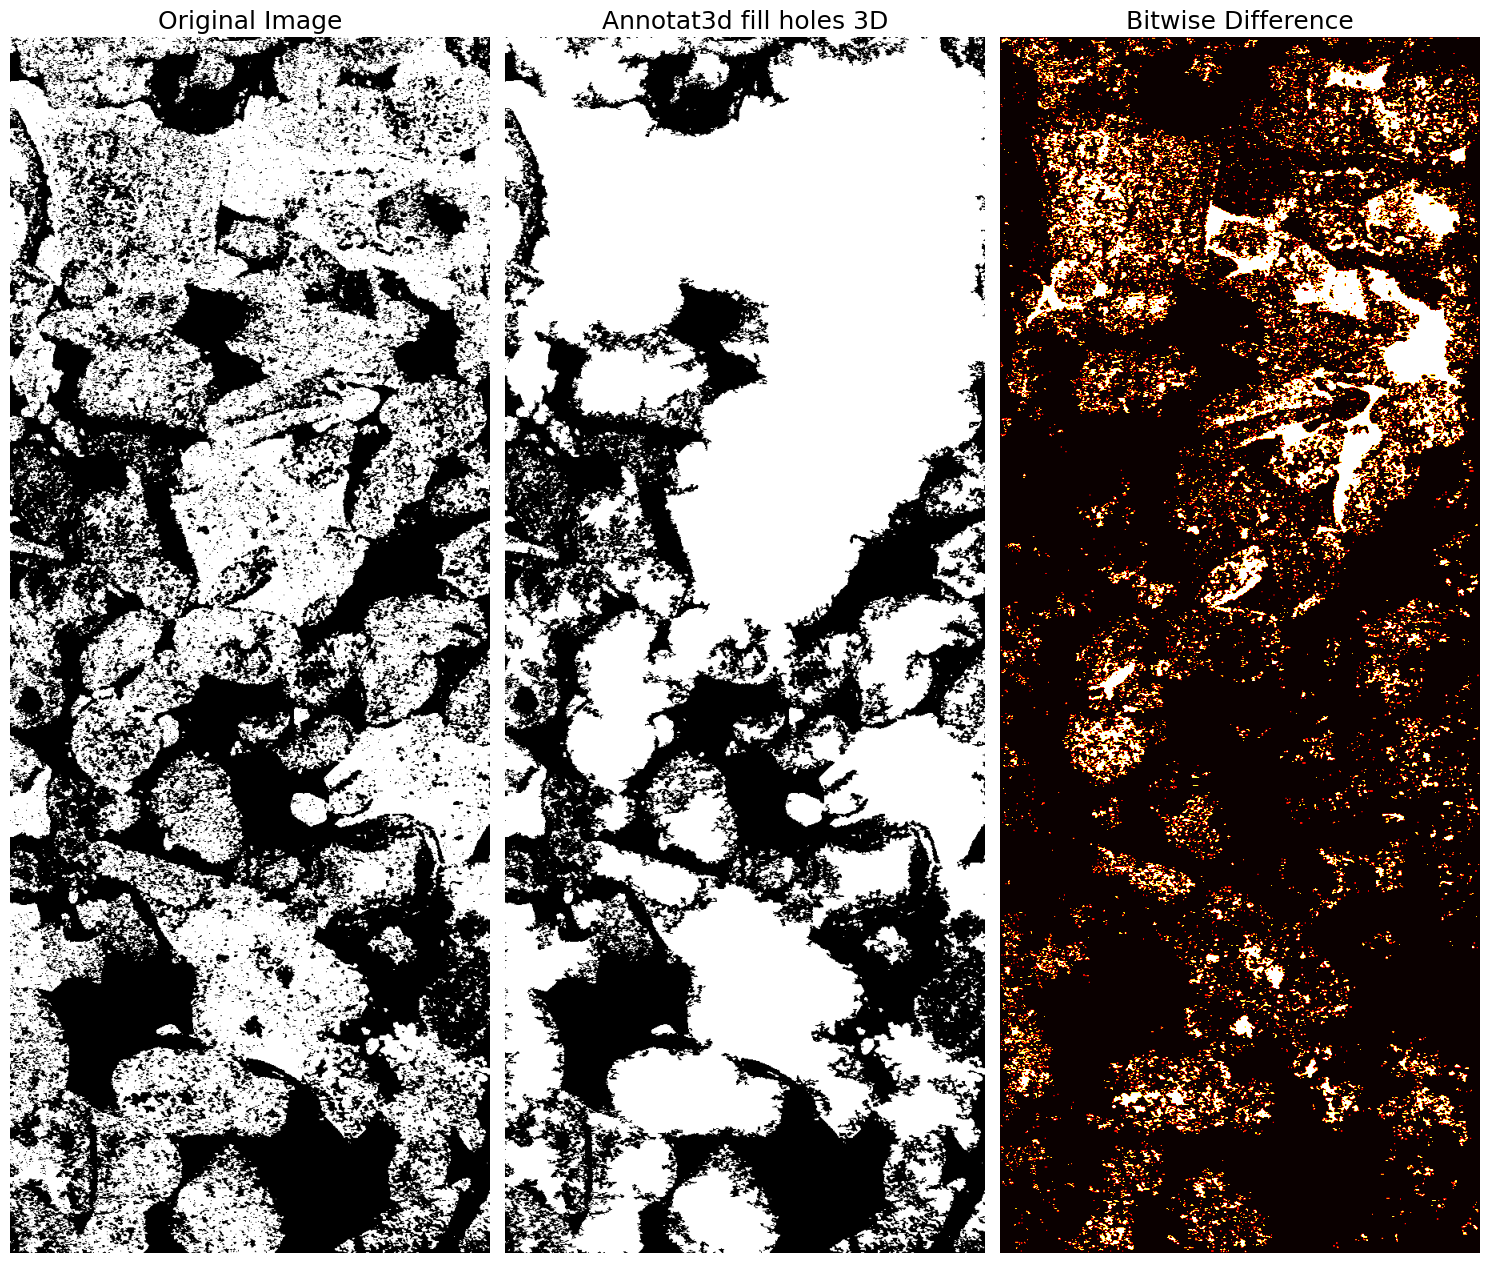

In [26]:
#Custum operation
result_custum = harpia_binary.fill_holes(image2_slice3D)

filename = f"{output_dir}/binary_fill_holes2_2D.png"
show_results_diff(result_custum, image2_slice3D, plot=True, operation = "fill holes 3D", slice_num=0, figsize = (15,30), save_path=filename)

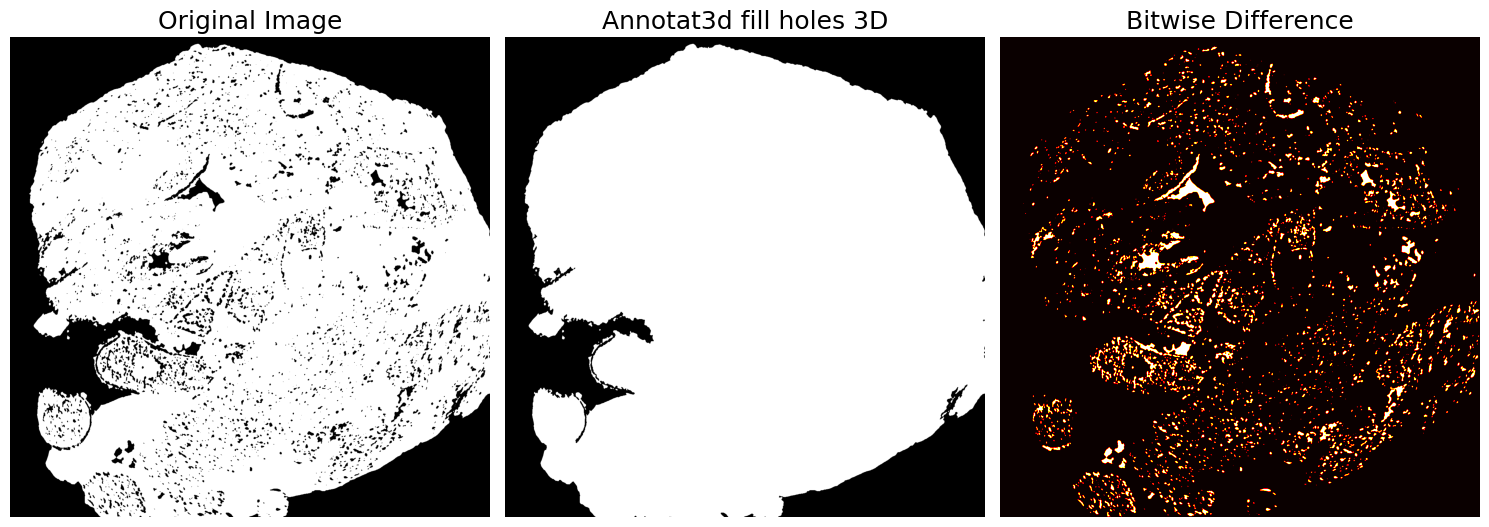

In [27]:
#Custum operation
result_custum = harpia_binary.fill_holes(image3_slice3D)
#result_custum = result_custum.squeeze()

filename = f"{output_dir}/binary_fill_holes3_2D.png"
show_results_diff(result_custum, image3_slice3D, plot=True, operation = "fill holes 3D", slice_num=0, figsize = (15,30), save_path=filename)

## Fill Holes 3D

In [28]:
result_custum = harpia_binary.fill_holes(image1)

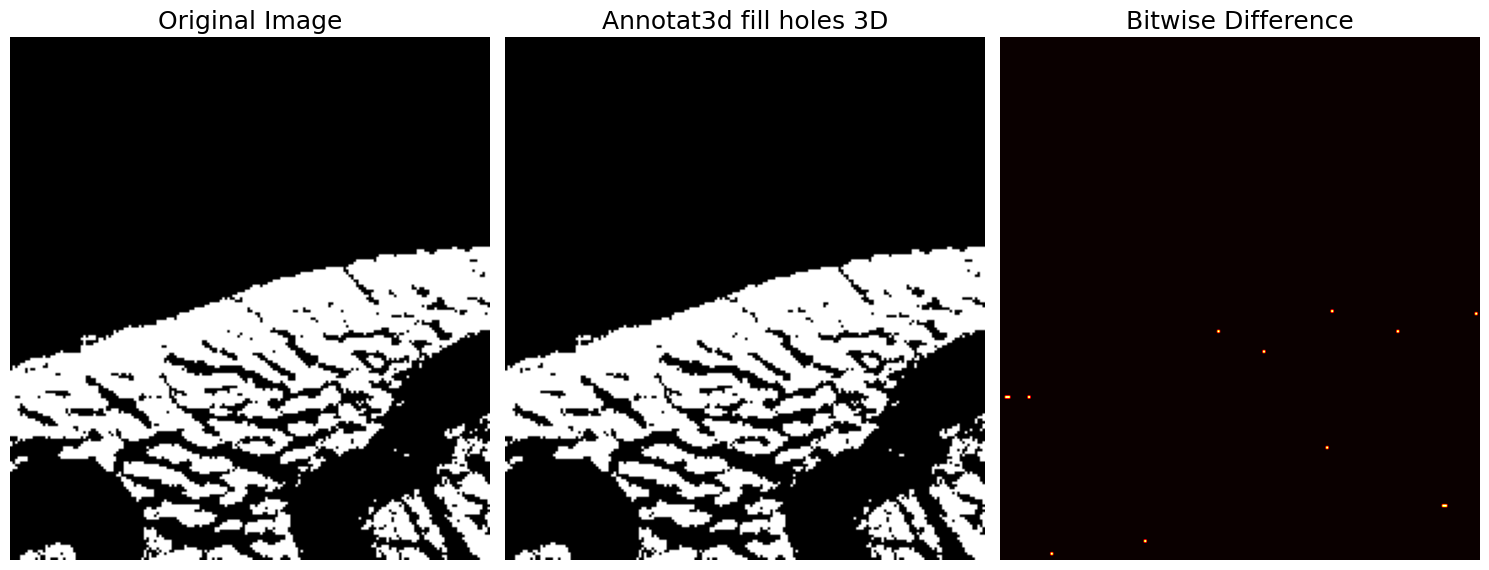

In [29]:
filename = f"{output_dir}/binary_fill_holes1_3D.png"
show_results_diff(result_custum, image1, plot=True, operation = "fill holes 3D", slice_num=10, figsize = (15,30), save_path=filename)

In [30]:
result_custum = harpia_binary.fill_holes(image2)

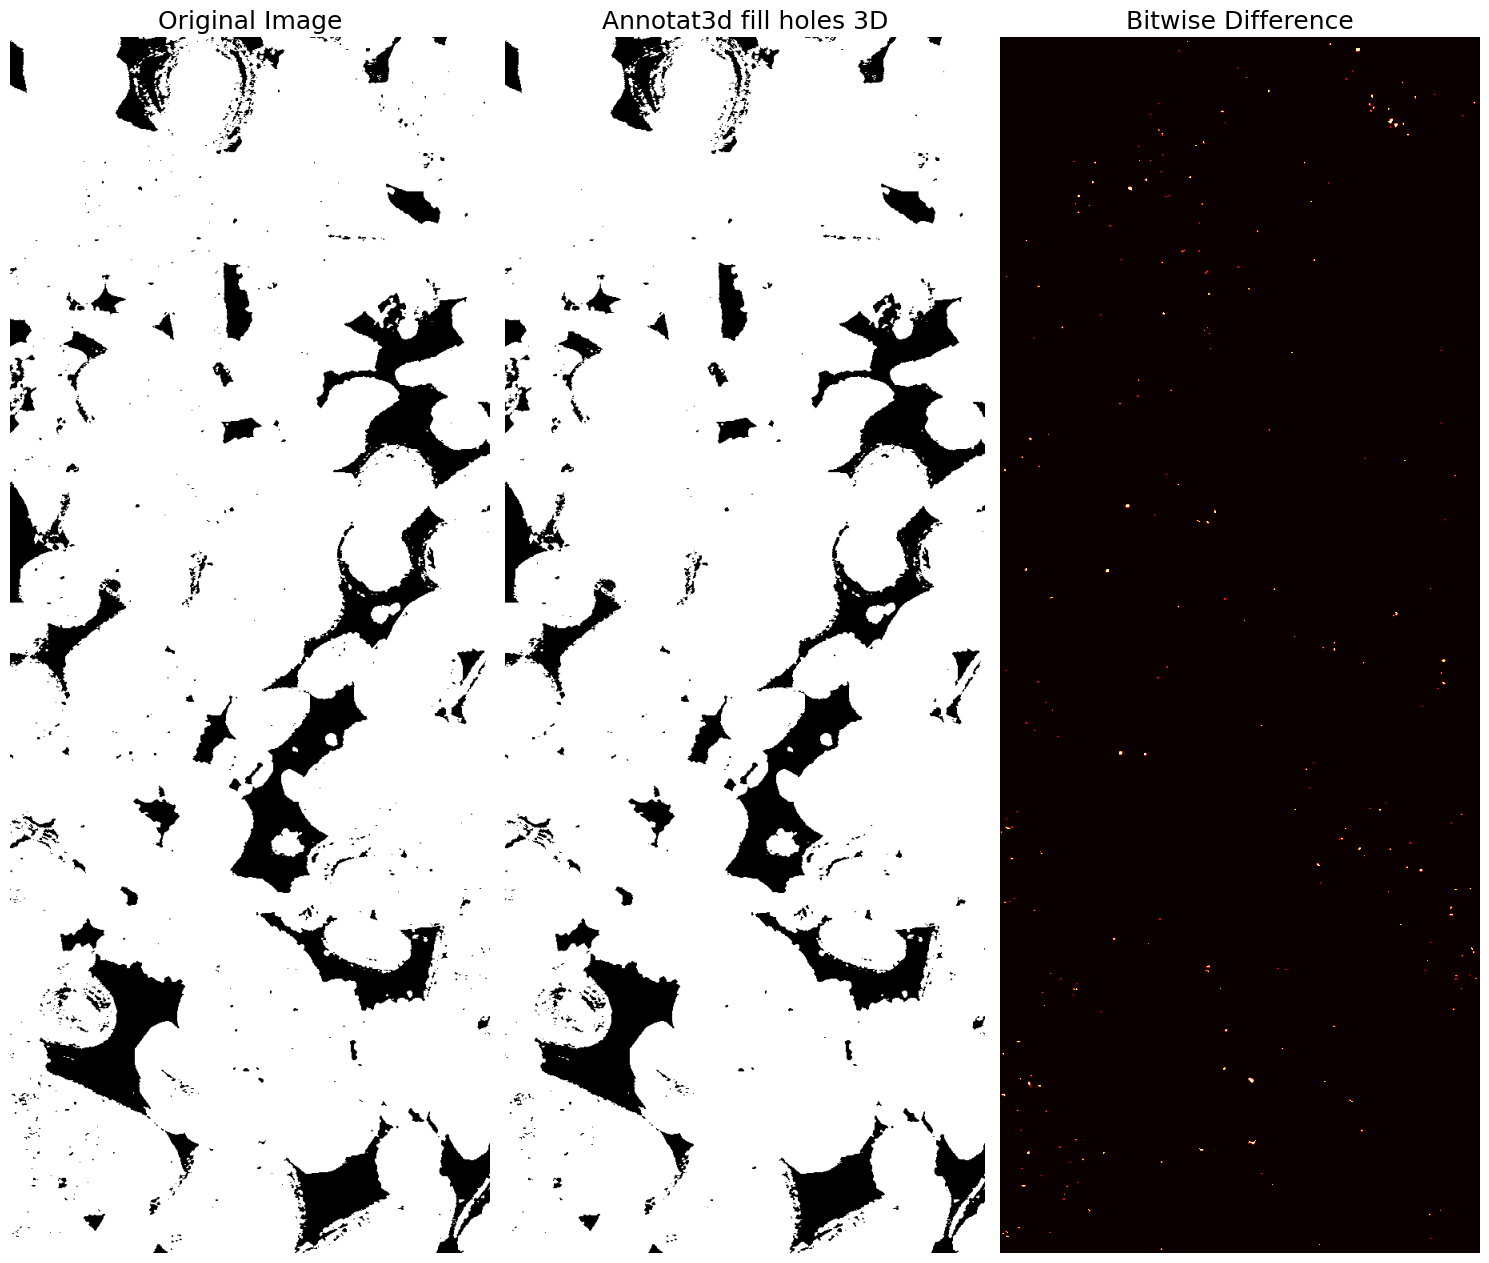

In [31]:
filename = f"{output_dir}/binary_fill_holes2_3D.png"
show_results_diff(result_custum, image2, plot=True, operation = "fill holes 3D", slice_num=30, figsize = (15,30), save_path=filename)

In [32]:
result_custum = harpia_binary.fill_holes(image3[:875,:,:])

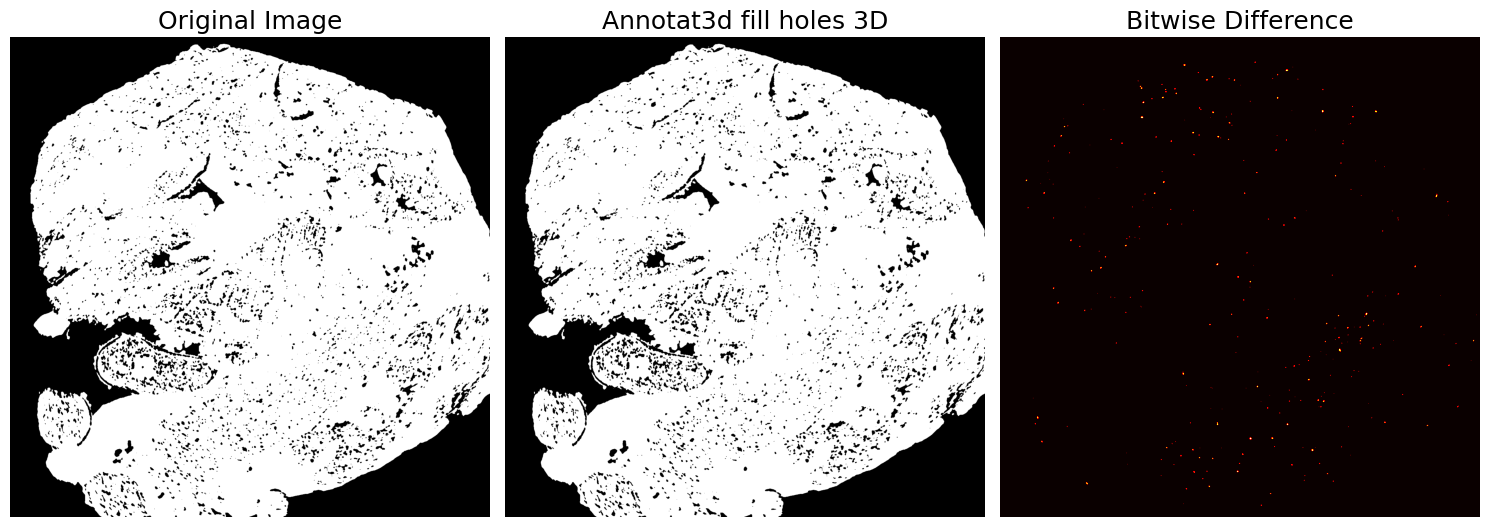

In [33]:
filename = f"{output_dir}/binary_fill_holes3_3D.png"
show_results_diff(result_custum, image3[:875,:,:], plot=True, operation = "fill holes 3D", slice_num=3, figsize = (15,30), save_path=filename)

## Test chunked Fill Holes

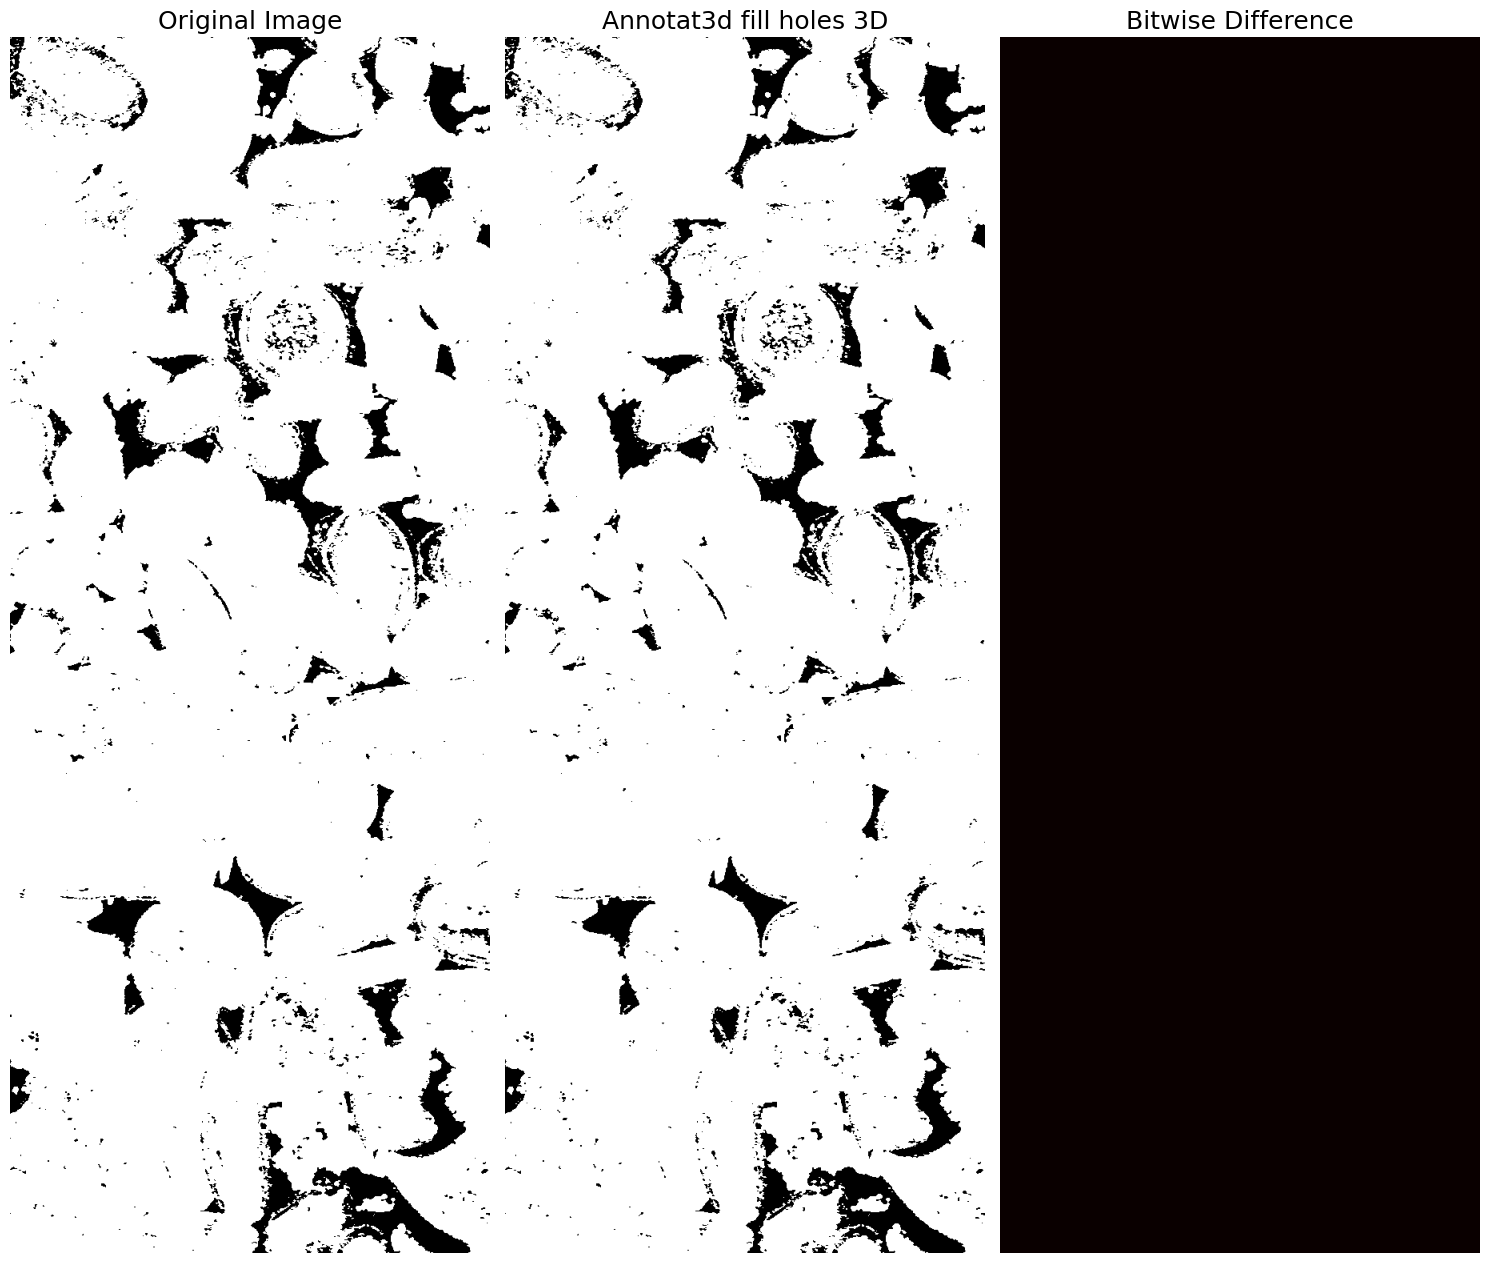

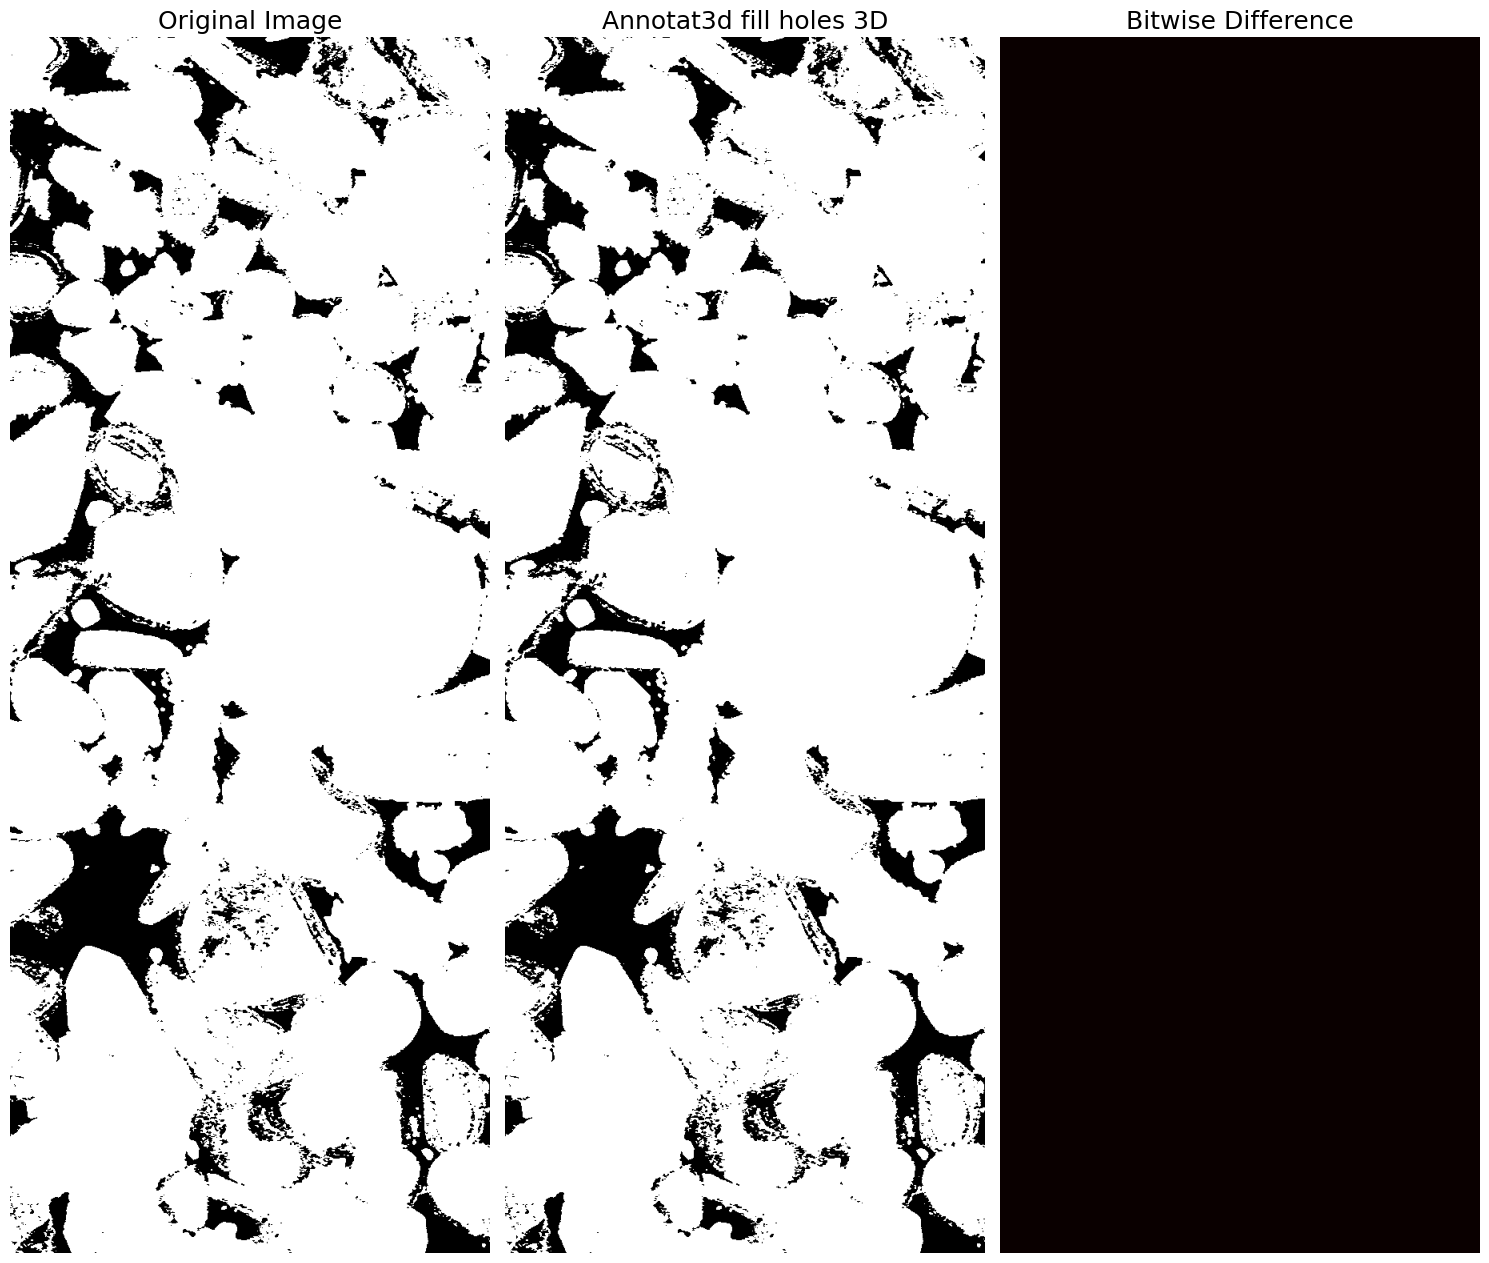

In [62]:
image_test = image2
zsize = image_test.shape[0]
chunksize = int(zsize/3)

result = harpia_binary.fill_holes(image_test)
result_1_chunk = harpia_binary.fill_holes(image_test[:chunksize*2,:,:])
result_2_chunk = harpia_binary.fill_holes(image_test[chunksize:,:,:])

result_chunk = np.zeros_like(result)
result_chunk[:chunksize,:,:] = result_1_chunk[:chunksize,:,:]
result_chunk[chunksize:chunksize*2,:,:] = result_1_chunk[chunksize:,:,:] | result_2_chunk[0:chunksize,:,:]
result_chunk[chunksize*2:,:,:] = result_2_chunk[chunksize:,:,:]

show_results_diff(result_chunk, result, plot=True, operation = "fill holes 3D", slice_num=chunksize, figsize = (15,30), save_path=None)
show_results_diff(result_chunk, result, plot=True, operation = "fill holes 3D", slice_num=chunksize*2, figsize = (15,30), save_path=None)

In [63]:
compare_slices(result,result_chunk)

[]

## Test chunked Fill Holes 2

In [38]:
# Input image
input_image = image3
# 1660120000 equivalent to a 1520x1520x700 image (the maximum executed without error
# Dimensions and processing parameters
depth_size = input_image.shape[0]
slice_size = input_image.shape[1]*input_image.shape[2]
max_chunk_size = np.floor(1660120000 / slice_size).astype(int)  # Round down and convert to int
num_chunks = np.ceil(depth_size / max_chunk_size).astype(int)
margin_size = 50
chunk_depth = depth_size // num_chunks
print(f"max_chunk_size: {max_chunk_size}")
print(f"num_chunks: {num_chunks}")
print(f"chunk_depth: {chunk_depth}")

# Process the image in chunks
chunk_results = []
for chunk_idx in range(num_chunks):
    start_depth = chunk_idx * chunk_depth
    end_depth = depth_size if chunk_idx == num_chunks - 1 else (chunk_idx + 1) * chunk_depth
    chunk = input_image[start_depth:end_depth, :, :]
    chunk_results.append(harpia_binary.fill_holes(chunk))

# Combine results from chunks
chunk_combined_result = np.concatenate(chunk_results)
#print(chunk_combined_result.shape, full_result.shape)

# Process margins between chunks
margin_results = np.zeros_like(input_image)
for chunk_idx in range(num_chunks - 1):
    margin_start = (chunk_idx + 1) * chunk_depth - margin_size
    margin_end = (chunk_idx + 1) * chunk_depth + margin_size
    margin_slice = input_image[margin_start:margin_end, :, :]
    margin_filled = harpia_binary.fill_holes(margin_slice)
    margin_results[margin_start:margin_end, :, :] |= margin_filled

print(margin_results.shape, margin_results.shape)

# Combine chunk results and margin results
final_result = chunk_combined_result | margin_results

max_chunk_size: 700
num_chunks: 2
chunk_depth: 500
(1000, 1540, 1540) (1000, 1540, 1540)


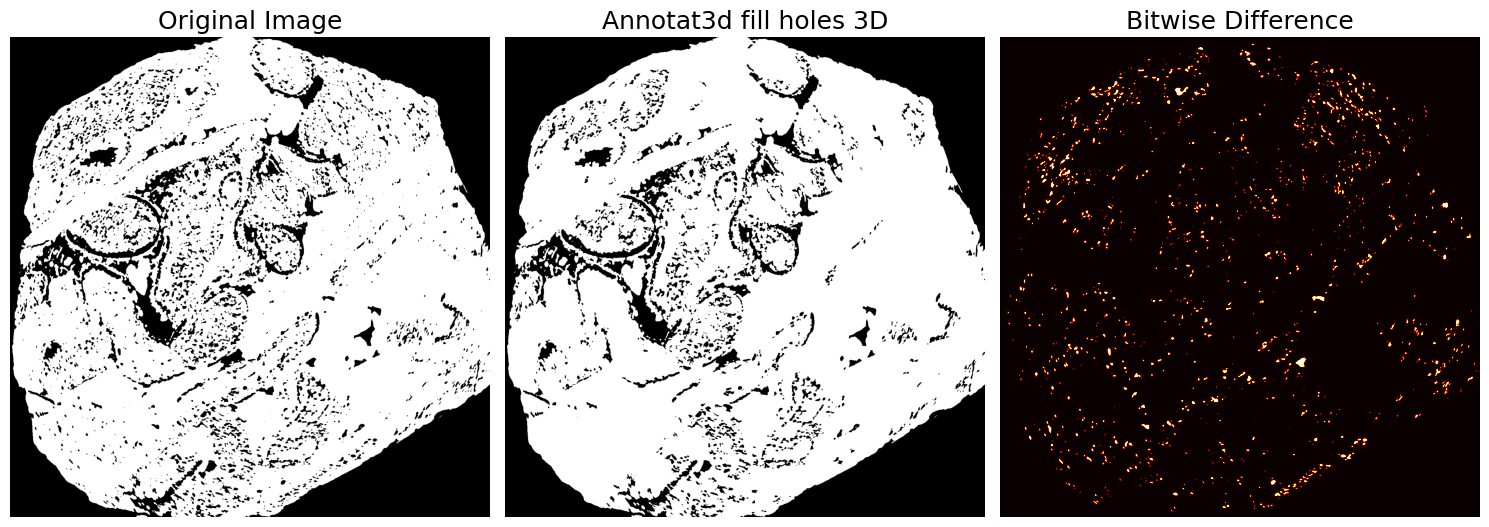

In [47]:
show_results_diff(final_result, image3, plot=True, operation = "fill holes 3D", slice_num=chunk_depth, figsize = (15,30), save_path=None)
